<a href="https://colab.research.google.com/github/mMaRuf1998/Image-Processing/blob/main/Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pickle
from tensorflow import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
import pandas as pd
from keras.datasets import cifar10
from keras.layers import Input, Dense
from keras.models import Model

base_dir = "/content/drive/MyDrive/apnea-ecg/1.0.0"

ir = 3 # interpolate interval
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [3]:
base_dir = "/content/drive/MyDrive/apnea-ecg/1.0.0"

ir = 3
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))


In [4]:
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "apnea-ecg2.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)

    x_train = []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_signal) = o_train[i]
        # Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_signal), k=3), ext=1)
        combined_signal = np.concatenate((rri_interp_signal, ampl_interp_signal))  # Combine the two signals
        x_train.append(combined_signal)
    x_train = np.array(x_train, dtype="float32")  # Convert to numpy format
    y_train = np.array(y_train, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_signal) = o_test[i]
        # Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_signal), k=3), ext=1)
        combined_signal = np.concatenate((rri_interp_signal, ampl_interp_signal))  # Combine the two signals
        x_test.append(combined_signal)
    x_test = np.array(x_test, dtype="float32")  # Convert to numpy format
    y_test = np.array(y_test, dtype="float32")

    return x_train, y_train, groups_train, x_test, y_test, groups_test

In [5]:
def create_model(input_shape, weight=1e-3):

    inputs = Input(shape=input_shape)

	# Conv1
    x = Conv1D(32, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(inputs)
    x = MaxPooling1D(pool_size=3)(x)

	# Conv3
    x = Conv1D(64, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x)
    x = MaxPooling1D(pool_size=3)(x)

    x = Dropout(0.8)(x)
    	# FC6
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr


def plot(history):
    from matplotlib import pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()


if __name__ == "__main__":
    x_train, y_train, groups_train, x_test, y_test, groups_test = load_data()

    print(x_train)

    print("train num:", len(y_train))
    print("test num:", len(y_test))

[[0.         0.         0.         ... 0.4936155  0.45841396 0.31752214]
 [0.         0.         0.         ... 0.82969093 0.7051687  0.        ]
 [0.         0.         0.         ... 0.8446995  0.         0.        ]
 ...
 [0.         0.         0.         ... 0.59414256 0.         0.        ]
 [0.         0.         0.         ... 0.5418224  0.5096765  0.        ]
 [0.         0.         0.         ... 0.2315064  0.         0.        ]]
train num: 16709
test num: 16945


In [8]:
clf1 = LinearDiscriminantAnalysis(solver='svd',tol=1e-4)
clf2 = QuadraticDiscriminantAnalysis(tol=8.30e-4)
clf3 = svm.SVC(kernel='rbf', C=252, gamma=0.75)
clf4 = KNeighborsClassifier(n_neighbors=11, metric='manhattan',leaf_size=70,p=1)
clf5= RandomForestClassifier(n_estimators=90, max_depth=11)
clf6= DecisionTreeClassifier(max_depth=5,splitter='best',criterion = 'gini')
clf7= ExtraTreesClassifier(n_estimators=80, max_depth=28,min_samples_split = 2,criterion = 'gini')
clf8 = MLPClassifier(hidden_layer_sizes=(50), activation='relu', max_iter=500, solver='adam', alpha=0.0001,
                     learning_rate='constant', learning_rate_init=0.001, tol=1e-4)
clf9 = GradientBoostingClassifier(n_estimators=80, max_depth=24, subsample=0.59, criterion='friedman_mse', loss='exponential')
clf10 = LogisticRegression(solver='lbfgs',C=95.78,tol=1e-4, penalty='l2')
clf11 = AdaBoostClassifier(n_estimators=70,learning_rate=0.39, algorithm='SAMME.R')
clf12 = GaussianNB(var_smoothing=0.00946)
clf13 = GaussianProcessClassifier(kernel=rbf_kernel, max_iter_predict=3, optimizer='fmin_l_bfgs_b', warm_start=True)
clf = VotingClassifier(
   estimators=[('C1',clf1),('C2',clf2),('C3',clf3)],
 voting='hard')

In [7]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import  VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier

rbf_kernel = RBF(length_scale=1.0)

In [9]:
clf.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


VotingClassifier(estimators=[('C1', LinearDiscriminantAnalysis()),
                             ('C2', QuadraticDiscriminantAnalysis(tol=0.00083)),
                             ('C3', SVC(C=252, gamma=0.75))])

In [10]:
y_pred = clf.predict(x_test)

In [19]:
     ACC=[]
     SN=[]
     SP=[]
     F2=[]
     from sklearn.metrics import f1_score
     C = confusion_matrix(y_test, y_pred, labels=(1, 0))
     TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
     acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
     f2=f1_score(y_test, y_pred)
     # APPENDING ACC,SN, SP, AND F2
     ACC.append(acc * 100)
     SN.append(sn * 100)
     SP.append(sp * 100)
     F2.append(f2 * 100)

In [20]:
print(C)

[[1782 4708]
 [1339 9116]]


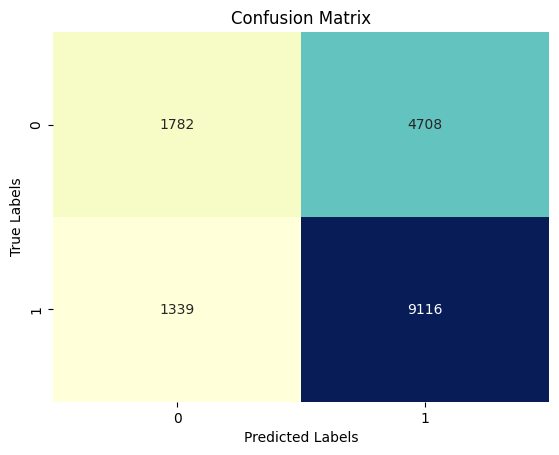

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=C,display_labels=(0, 1))
import matplotlib.pyplot as plt
sns.heatmap(C, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/content/drive/MyDrive/apnea-ecg/1.0.0/First3_Conf.png",dpi=1200)
plt.show()


In [22]:
print(f2)

0.3708250962438872


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.87      0.75     10455
         1.0       0.57      0.27      0.37      6490

    accuracy                           0.64     16945
   macro avg       0.62      0.57      0.56     16945
weighted avg       0.63      0.64      0.61     16945

